# Testing LIME for visual explanations of model's predictions

In [13]:
# imports
import os
import random
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from data_utils.data_stats import *
from models.resnet import resnet18
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm
from models.networks import get_model

from skimage.measure import label
from skimage.color import label2rgb

In [2]:
# Dataset Configuration
dataset_name = 'cifar10'
mean = MEAN_DICT[dataset_name]
std = STD_DICT[dataset_name]
num_classes = CLASS_DICT[dataset_name]
dataset_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

assert len(dataset_classes) == num_classes

Files already downloaded and verified


In [3]:
# Setup dataloader
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=512,
                                          shuffle=True,
                                          num_workers=2)

Select the architecture by executing the corresponding cell and follow the comments below.

In [4]:
# ResNet Configuration
model = resnet18(pretrained=True)
model_transform = transforms.Compose([
    transforms.Normalize(mean / 255., std / 255.)
])

In [502]:
# MLP Configuration
mlp_architecture = 'B_12-Wi_512'  # B_12-Wi_512
mlp_resolution = 64  # Resolution of fine-tuned model (64 for all models we provide)
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")
mlp_checkpoint = 'in21k_cifar10'  # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
model = get_model(architecture=mlp_architecture, resolution=mlp_resolution, num_classes=num_classes,
                  checkpoint=mlp_checkpoint)
model_transform = transforms.Compose([
    transforms.transforms.Resize((mlp_resolution, mlp_resolution)),
    transforms.Normalize(mean / 255., std / 255.)
])

Weights already downloaded
Load_state output <All keys matched successfully>


In [26]:
# get random image
def get_random_image():
    image_nr = random.randrange(len(dataset))  # random image
    # image_nr = 9297  # specific image id

    image, true_label = dataset[image_nr]
    
    image_np = image.numpy().transpose((1, 2, 0))
    plt.imshow(image_np)
    plt.show()
    
    print(f"Picked image {image_nr} with true label '{dataset_classes[true_label]}'.")
    
    return image, true_label

# reshape to get input tensor for a particular image
def get_input_tensor(img):
    img = model_transform(img).unsqueeze(0)
    # img = torch.reshape(img, (img.shape[0], -1)) # enable with MLP
    return img

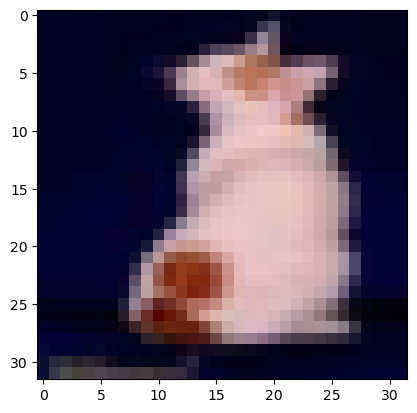

Picked image 5084 with true label 'cat'.
Predicted 'cat' with probability 94.95%'


In [27]:
# prediction of our model
model.eval()

with torch.no_grad():
    img, true_label = get_random_image() # 4136, 6358, 4073, 4991, 9297
    output = model(get_input_tensor(img))
    probabilities = torch.nn.functional.softmax(output, dim=-1).squeeze()
    predicted_class = torch.argmax(probabilities).item()

    predicted_label = dataset_classes[predicted_class]
    
    print(f"Predicted '{predicted_label}' with probability {(probabilities[predicted_class] * 100):.2f}%'")

In [52]:
lime_transform = transforms.Compose([
    transforms.ToTensor(),
    model_transform
])
def batch_predict(images):
    model.eval()
    
    batch = torch.stack([lime_transform(i) for i in images])
    # batch = torch.reshape(batch, (batch.shape[0], -1))  # enable if MLP
    
    # pick random sample from batch and perform classification
    random_idx = random.randrange(len(images))
    plt.imshow(images[random_idx])
    plt.show()
    
    sample_logits = model(batch[random_idx].unsqueeze(0))
    sample_probs = torch.nn.functional.softmax(sample_logits, dim=-1).squeeze()
    sample_class = torch.argmax(sample_probs).item()
    sample_label = dataset_classes[sample_class]
    print(f"Predicted '{sample_label}' with probability {(sample_probs[sample_class] * 100):.2f}%'")

    with torch.no_grad():
        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
        return probs

In the next stage, we will perform LIME analyzis on the random image.
The parameters can be adjusted:
- top_labels: selects the K topmost predicted classes to perform the analysis
- hide_color: if not specified, avg of segment is used to mask out part of the image
- segmentation_fn: which segmentation algorithm to be used
- num_samples: number of images that will be classified

Here we can certainly play around with the **segmentation algorithm** and hyperparameters thereof.<br>
Default is quickshift(kernel_size=4, max_dist=200, ratio=0.2)

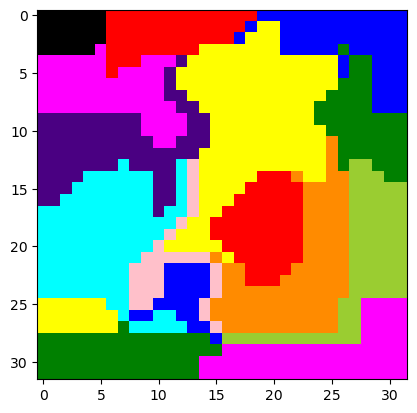

In [53]:
# specify segmentation algorithm

# segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)  # default
segmentation_fn = SegmentationAlgorithm('felzenszwalb', scale=1, sigma=.8)
segmentation_mask = segmentation_fn(img.numpy().transpose(1, 2, 0))

# can specify image=img.numpy().transpose(1, 2, 0) to get overlay
image_label_overlay = label2rgb(segmentation_mask, image=None, bg_label=0, alpha=0.1)

plt.imshow(image_label_overlay)

  0%|          | 0/100 [00:00<?, ?it/s]

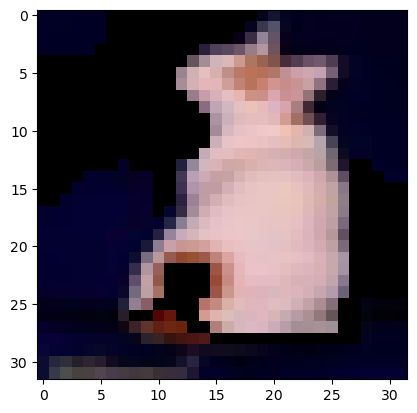

Predicted 'cat' with probability 80.88%'


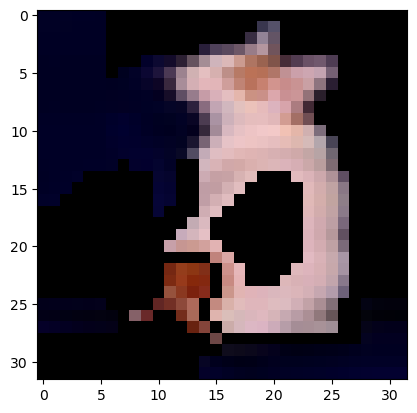

Predicted 'bird' with probability 43.09%'


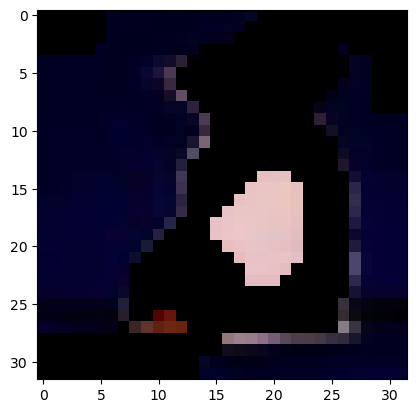

Predicted 'bird' with probability 74.69%'


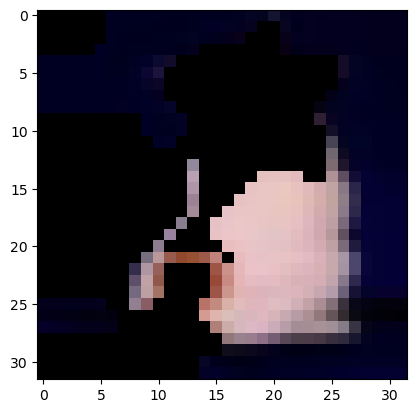

Predicted 'deer' with probability 56.00%'


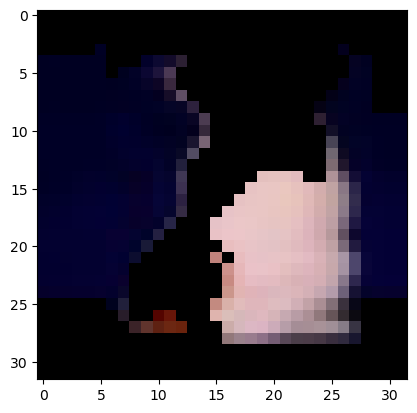

Predicted 'bird' with probability 75.75%'


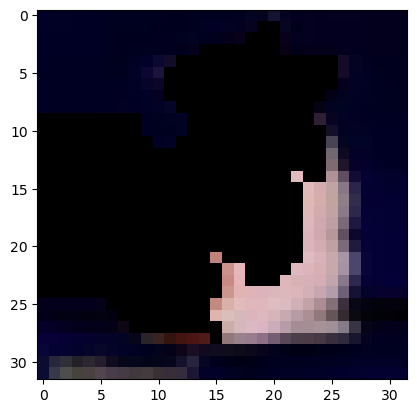

Predicted 'cat' with probability 69.79%'


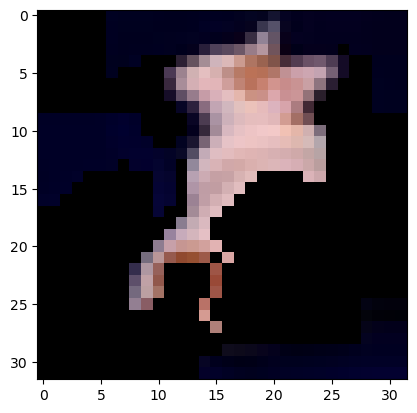

Predicted 'airplane' with probability 50.47%'


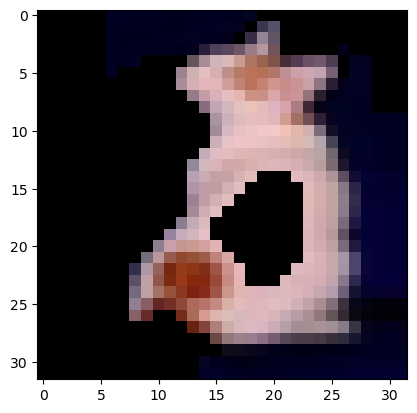

Predicted 'cat' with probability 80.83%'


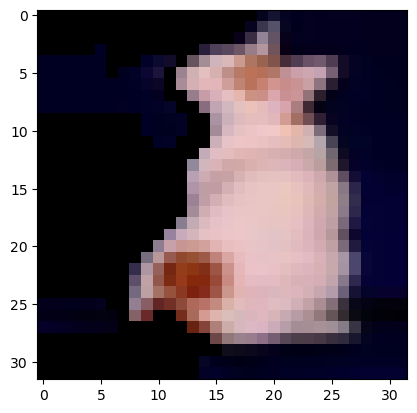

Predicted 'cat' with probability 94.92%'


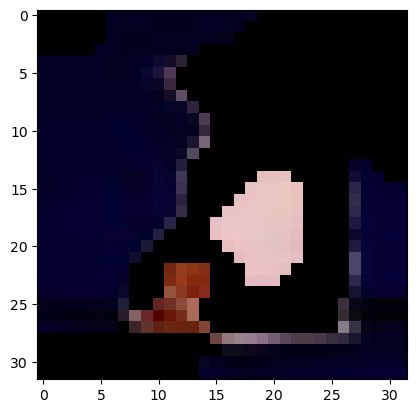

Predicted 'deer' with probability 60.74%'


In [54]:
# Perform LIME operations
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img.numpy().transpose(1, 2, 0), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0,
                                         segmentation_fn=segmentation_fn,
                                         num_samples=100) # number of images that will be sent to classification

The next two cells show the results. The parameters are:
- positive_only: only show the areas (segments) that correlate with the top label
- num_features: somehow indicates the size of the correlated area
- hide_rest: whether the unnecessary parts of the image should be masked out

Here, one can certainly play around with the **num_features** parameter

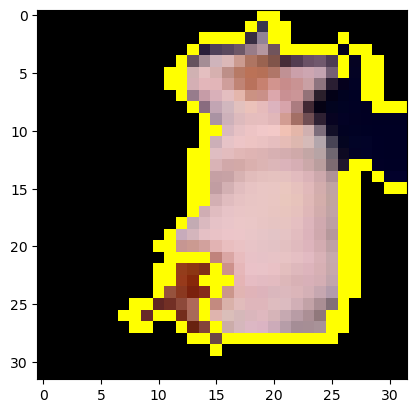

In [55]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry)

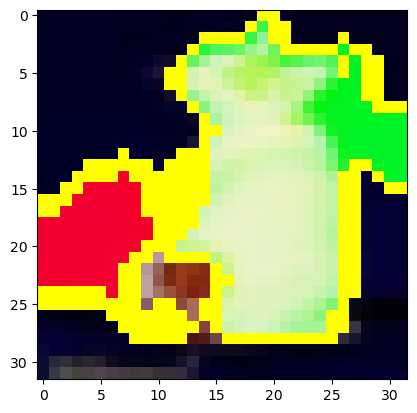

In [56]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry)